<a href="https://colab.research.google.com/github/tayiba-r/tayiba_INFO5731_SPRING2023/blob/main/exercises/In_class_exercise_04_03282023_Tayiba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 03/28/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Write your code here
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 33.8 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
twitter_csv_file_df = pd.read_csv("https://raw.githubusercontent.com/tayiba-r/tayiba_INFO5731_SPRING2023/main/rihanna_hashtag.csv")
#Cleaning the data
import re

def cleantext(tweets):
    cleaned_text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    cleaned_text = re.sub(r'#[A-Za-z0-9_]+', '', cleaned_text) #removing Hashtag symbols.
    cleaned_text = re.sub(r'RT[\s]+', '', cleaned_text) #removing Retweet symbol (RT).
    cleaned_text = re.sub(r'https?:\/\/\S+', '', cleaned_text) #remove URL's.
    cleaned_text = re.sub(r"www.\S+", "", cleaned_text)
    cleaned_text = re.sub('[()!?]', ' ', cleaned_text)
    cleaned_text = re.sub('\[.*?\]',' ', cleaned_text)
    cleaned_text = re.sub("[^A-Za-z0-9]"," ", cleaned_text)#Filtering non-alphanumeric characters
    cleaned_text = re.sub('\\n', '', cleaned_text)#removing the '\n' character
    cleaned_text = re.sub(r'[0-9]+', '', cleaned_text)#removing numbers
    
    return cleaned_text

twitter_csv_file_df["Tweet"] = twitter_csv_file_df["Tweet"].apply(cleantext)

# Convert to list
data = twitter_csv_file_df.Tweet.values.tolist()

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
b = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
t = gensim.models.Phrases(b[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bmod = gensim.models.phrases.Phraser(b)
tmod = gensim.models.phrases.Phraser(t)

# See trigram example
print(tmod[bmod[data_words[0]]])

['just', 'reminder', 'that', 'this', 'woman', 'stood', 'up', 'to', 'all', 'haters', 'when', 'man', 'cleared', 'his', 'name', 'from', 'false', 'accusations', 'she', 'the', 'queen', 'you', 're', 'our', 'hero']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bmod[doc] for doc in texts]

def make_trigrams(texts):
    return [tmod[bmod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_no_stops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_no_stops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['reminder', 'woman', 'stand', 'hater', 'man', 'clear', 'name', 'false', 'accusation', 'queen', 'hero']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


In [ ]:
id2word[0]

'accusation'

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accusation', 1),
  ('clear', 1),
  ('false', 1),
  ('hater', 1),
  ('hero', 1),
  ('man', 1),
  ('name', 1),
  ('queen', 1),
  ('reminder', 1),
  ('stand', 1),
  ('woman', 1)]]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.074*"get" + 0.030*"game" + 0.023*"expect" + 0.021*"think" + 0.021*"baby" + 0.019*"pregnancy" + 0.016*"brand" + 0.016*"rihanna" + 0.015*"money" + 0.014*"never"'), (1, '0.022*"minute" + 0.018*"man" + 0.018*"team" + 0.016*"guy" + 0.016*"part" + 0.016*"set" + 0.015*"drop" + 0.015*"call" + 0.014*"news" + 0.012*"choose"'), (2, '0.067*"love" + 0.031*"find" + 0.019*"riri" + 0.016*"much" + 0.016*"thank" + 0.014*"month" + 0.014*"barbado" + 0.013*"good" + 0.012*"beauty" + 0.012*"miss"'), (3, '0.028*"time" + 0.024*"learn" + 0.023*"today" + 0.022*"work" + 0.021*"still" + 0.020*"way" + 0.020*"album" + 0.018*"day" + 0.016*"top" + 0.016*"favorite"'), (4, '0.036*"move" + 0.036*"go" + 0.026*"dance" + 0.022*"place" + 0.019*"stand" + 0.018*"side" + 0.017*"make" + 0.014*"valentine_day" + 0.014*"star" + 0.014*"try"'), (5, '0.061*"show" + 0.042*"song" + 0.034*"music" + 0.022*"lift" + 0.022*"stage" + 0.020*"perform" + 0.018*"moment" + 0.016*"away" + 0.015*"half_time" + 0.015*"help"'), (6, '0.029*"woma

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.928142034201797

Coherence Score:  0.479479996315782


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.117791 -0.236987       1        1  15.773698
7     -0.266366  0.120693       2        1  15.614889
9      0.122618  0.205017       3        1  12.151067
6     -0.111054  0.058381       4        1  12.098051
3      0.134878 -0.077076       5        1   9.905751
0      0.106605 -0.012780       6        1   9.528057
2      0.021035 -0.001159       7        1   7.682004
1      0.050613 -0.014128       8        1   6.225621
4      0.020029  0.013884       9        1   5.835275
8      0.039434 -0.055846      10        1   5.185587, topic_info=             Term        Freq       Total Category  logprob  loglift
170   performance  136.000000  136.000000  Default  30.0000  30.0000
244          show   87.000000   87.000000  Default  29.0000  29.0000
125           get   75.000000   75.000000  Default  28.0000  28.0000
322          love   47.000000   47.000000  Default  27.0000  27.0000
98          music   68.000000   68.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
758           fan    6.832114   13.464023  Topic10  -4.2399   2.2809
1307         rise    5.149973    9.165105  Topic10  -4.5226   2.3829
98          music   16.574880   68.195414  Topic10  -3.3537   1.5448
709          even    4.427053   11.367482  Topic10  -4.6738   2.0163
175          lift    3.811702   36.327437  Topic10  -4.8235   0.7048

[394 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1658      8  0.921386  absolutely
2062      6  0.944589      accept
1068      6  0.778181    actually
1621      7  0.962576          ad
1653      5  0.966965         air
...     ...       ...         ...
645       5  0.977170        work
564       2  0.974659       world
121       1  0.212001        year
121       2  0.777336        year
1640      2  0.919903   yesterday

[394 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 10, 7, 4, 1, 3, 2, 5, 9])

In [ ]:
!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=26528032 sha256=ee4a73785f012e5e497bc5e2e34eb85fc3871344300736cdea7473c8c12711bf
  Stored in directory: /root/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.2
    Uninstalling gensim-3.8.2:
      Successfully uninstalled gensim-3.8.2


In [ ]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet

mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = LdaMallet(mallet_path, corpus=common_corpus, num_topics=20, id2word=id2word)


--2023-04-03 04:02:41--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-04-03 04:02:41--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.12’

mallet-2.0.8.zip.12 100%[===================>]  15.43M  60.3MB/s    in 0.3s    

2023-04-03 04:02:41 (60.3 MB/s) - ‘mallet-2.0.8.zip.12’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2cla

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

/usr/local/lib/python3.9/dist-packages/gensim/models/wrappers/ldamallet.py:448: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist
/usr/local/lib/python3.9/dist-packages/gensim/models/wrappers/ldamallet.py:379: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


[(9,
  [('situate', nan),
   ('brush', nan),
   ('intentional', nan),
   ('represent', nan),
   ('premiere', nan),
   ('theater', nan),
   ('harness', nan),
   ('protective', nan),
   ('scary', nan),
   ('moonwalk', nan)]),
 (14,
  [('situate', nan),
   ('brush', nan),
   ('intentional', nan),
   ('represent', nan),
   ('premiere', nan),
   ('theater', nan),
   ('harness', nan),
   ('protective', nan),
   ('scary', nan),
   ('moonwalk', nan)]),
 (2,
  [('queen', 0.25),
   ('accusation', 0.25),
   ('stand', 0.25),
   ('reminder', 0.25),
   ('harness', 0.0),
   ('scary', 0.0),
   ('protective', 0.0),
   ('brush', 0.0),
   ('represent', 0.0),
   ('premiere', 0.0)]),
 (18,
  [('situate', nan),
   ('brush', nan),
   ('intentional', nan),
   ('represent', nan),
   ('premiere', nan),
   ('theater', nan),
   ('harness', nan),
   ('protective', nan),
   ('scary', nan),
   ('moonwalk', nan)]),
 (0,
  [('situate', nan),
   ('brush', nan),
   ('intentional', nan),
   ('represent', nan),
   ('premi

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

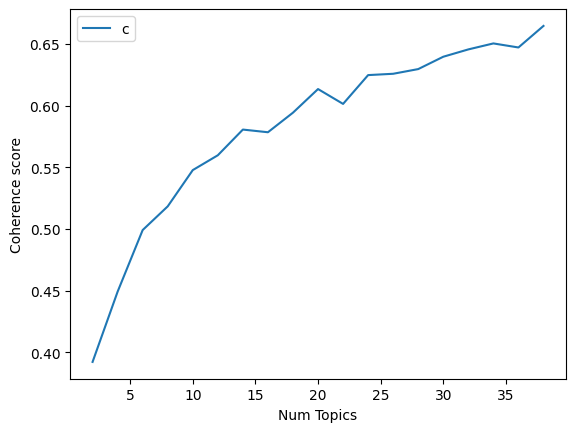

In [ ]:
 # Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3923
Num Topics = 4  has Coherence Value of 0.4493
Num Topics = 6  has Coherence Value of 0.4992
Num Topics = 8  has Coherence Value of 0.5184
Num Topics = 10  has Coherence Value of 0.5477
Num Topics = 12  has Coherence Value of 0.5598
Num Topics = 14  has Coherence Value of 0.5806
Num Topics = 16  has Coherence Value of 0.5784
Num Topics = 18  has Coherence Value of 0.5943
Num Topics = 20  has Coherence Value of 0.6134
Num Topics = 22  has Coherence Value of 0.6014
Num Topics = 24  has Coherence Value of 0.6247
Num Topics = 26  has Coherence Value of 0.6258
Num Topics = 28  has Coherence Value of 0.6296
Num Topics = 30  has Coherence Value of 0.6396
Num Topics = 32  has Coherence Value of 0.6455
Num Topics = 34  has Coherence Value of 0.6504
Num Topics = 36  has Coherence Value of 0.6471
Num Topics = 38  has Coherence Value of 0.6646


In [ ]:
# Select the model and print the topics
optimal_model = model_list[14]
#model_list[4] indicates that: model_list is a list that has been defined earlier and contains the number of topics and its coherence values.
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(6,
  '0.219*"love" + 0.065*"fan" + 0.065*"check" + 0.058*"favorite" + '
  '0.018*"power" + 0.018*"celebrate" + 0.018*"mile" + 0.018*"early" + '
  '0.014*"sheer" + 0.014*"spotify"'),
 (8,
  '0.066*"halftime_show" + 0.066*"expect" + 0.058*"performance" + '
  '0.047*"minute" + 0.039*"riri" + 0.031*"tribute" + 0.031*"pregnant" + '
  '0.031*"put" + 0.027*"coat" + 0.023*"beyonce"'),
 (26,
  '0.068*"give" + 0.064*"bring" + 0.037*"run" + 0.032*"feat" + 0.027*"young" + '
  '0.027*"eat" + 0.027*"real" + 0.023*"literally" + 0.018*"proud" + '
  '0.018*"air"'),
 (23,
  '0.115*"learn" + 0.071*"listen" + 0.063*"top" + 0.051*"lesson" + '
  '0.047*"business" + 0.032*"speak" + 0.028*"worth" + 0.028*"hear" + '
  '0.028*"billionaire" + 0.028*"future"'),
 (21,
  '0.264*"show" + 0.050*"half_time" + 0.034*"app" + 0.031*"boy" + 0.031*"pop" '
  '+ 0.027*"deliver" + 0.019*"clip" + 0.015*"number" + 0.015*"trend" + '
  '0.015*"magazine"'),
 (27,
  '0.137*"oscar" + 0.109*"live" + 0.047*"photo" + 0.035*"yesterday

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
# Write your code here
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
preprocess_data(data)

[['remind',
  'woman',
  'stood',
  'hater',
  'man',
  'clear',
  'name',
  'fals',
  'accus',
  'queen',
  'hero'],
 ['top',
  'financi',
  'fit',
  'lesson',
  'past',
  'dictat',
  'futur',
  'let',
  'circumst',
  'stand',
  'way',
  'becom',
  'billionair',
  'learn',
  'ep'],
 ['rebel',
  'black',
  'ring',
  'carat',
  'pear',
  'shape',
  'diamond',
  'botswana',
  'amp',
  'set',
  'black',
  'ceram',
  'gold',
  'thelma',
  'west',
  'wore',
  'part',
  'crown',
  'coutur',
  'exhibit',
  'open',
  'april',
  'th',
  'kensington',
  'palac'],
 ['f',
  'past',
  'dictat',
  'futur',
  'listen',
  'ep',
  'hear',
  'financi',
  'fit',
  'lesson',
  'rihanna',
  'amp',
  'jay',
  'z',
  'find'],
 ['time',
  'rock',
  'roll',
  'gal',
  'v',
  'seven',
  'year',
  'ago',
  'rihanna',
  'prank',
  'jimmi',
  'kimmel'],
 ['hollywood', 'billionair', 'club'],
 ['hide', 'paparazzi', 'behind', 'tint', 'window'],
 ['peac',
  'name',
  'alway',
  'associ',
  'anti',
  'nation',
  'activ

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
number_of_topics=7
words=10

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

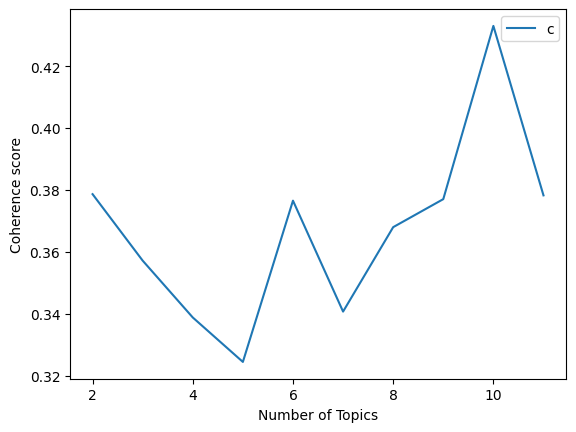

In [ ]:
start,stop,step=2,12,1
plot_graph(preprocess_data(data),start,stop,step)

In [ ]:
# Write your code here
model=create_gensim_lsa_model(preprocess_data(data),number_of_topics,words)

[(0, '0.487*"rihanna" + 0.376*"perform" + 0.249*"lift" + 0.246*"black" + 0.233*"th" + 0.215*"forev" + 0.215*"place" + 0.209*"panther" + 0.209*"wakanda" + 0.200*"song"'), (1, '-0.318*"perform" + -0.300*"super" + -0.291*"bowl" + 0.290*"th" + -0.287*"show" + 0.283*"place" + 0.222*"panther" + 0.222*"lift" + 0.222*"wakanda" + 0.221*"forev"'), (2, '-0.438*"place" + -0.435*"rihanna" + 0.420*"song" + 0.305*"perform" + -0.272*"th" + 0.180*"oscar" + 0.143*"best" + 0.139*"lift" + 0.137*"black" + 0.124*"forev"'), (3, '0.573*"song" + -0.376*"perform" + 0.249*"best" + 0.189*"origin" + -0.187*"black" + -0.168*"forev" + -0.162*"wakanda" + -0.161*"panther" + -0.145*"lift" + 0.144*"win"'), (4, '0.538*"perform" + -0.391*"rihanna" + 0.353*"place" + 0.309*"th" + -0.165*"show" + 0.129*"amp" + -0.127*"lift" + -0.125*"black" + -0.124*"panther" + -0.119*"wakanda"'), (5, '0.348*"show" + -0.296*"rihanna" + -0.279*"perform" + 0.271*"amp" + 0.237*"black" + 0.217*"love" + 0.205*"one" + 0.205*"music" + 0.186*"like" 

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
# Write your code here
import pyLDAvis
pyLDAvis.enable_notebook()

In [ ]:
!pip install lda2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install lda2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis
pyLDAvis.enable_notebook()

In [ ]:
from google.colab import files
uploades = files.upload()


Saving topics.pyldavis.npz to topics.pyldavis.npz


In [ ]:
npz = np.load(open('/content/topics.pyldavis.npz', 'rb'), allow_pickle=True)
dat = {k: v for (k, v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()


In [ ]:
top_n = 10
topic_to_topwords = {}
for j, topic_to_word in enumerate(dat['topic_term_dists']):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i '  % j
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    msg += ' '.join(top_words)
    print(msg)
    topic_to_topwords[j] = top_words

Topic 0 jesus god orthodox faith verse worship belief christianity christian mormon
Topic 1 bike tire honda battery brake ride valve aluminum intake jeep
Topic 2 game team play win baseball score playoff mets goal phillies
Topic 3 shuttle nasa space payload computational planetary satellite mission launch lunar
Topic 4 armenian troop cyprus israel soldier agdam bayonet terror bullet he
Topic 5 drive controller battery dock connector ink card slot pin vram
Topic 6 key encrypt cryptosystem encryption cryptography secure rsa crypto eavesdrop decrypt
Topic 7 ride revolver bike bikers go jeep i dog a tank
Topic 8 homicide gun handgun firearm fbi unconstitutional federal smuggle drug weapon
Topic 9 israel armenian plo cyprus troop lebanese arab palestinian syria turkish
Topic 10 armenian bayonet arena team turkish tartar nhl playoff game defenseman
Topic 11 widget server contrib font editor format mit pixmap toolkit binary
Topic 12 controller card disk bios rom vram drive isa vga trident
Top

In [ ]:
import warnings
warnings.filterwarnings('ignore')
prepared_data = pyLDAvis.prepare(dat['topic_term_dists'], dat['doc_topic_dists'], 
                                 dat['doc_lengths'] * 1.0, dat['vocab'], dat['term_frequency'] * 1.0, mds='tsne')

In [ ]:
pyLDAvis.display(prepared_data)

In [ ]:
from sklearn.datasets import fetch_20newsgroups
remove=('headers', 'footers', 'quotes')
texts = fetch_20newsgroups(subset='train', remove=remove).data

In [ ]:
data=pd.DataFrame(texts)

In [ ]:
data=data.rename(columns={0:'News_text'})

In [ ]:
data['News_text']=data['News_text'].str.lower()

In [ ]:
data['News_text'].head()

0    i was wondering if anyone out there could enli...
1    a fair number of brave souls who upgraded thei...
2    well folks, my mac plus finally gave up the gh...
3    \ndo you have weitek's address/phone number?  ...
4    from article <c5owcb.n3p@world.std.com>, by to...
Name: News_text, dtype: object

In [ ]:
#Remving the numbers from the news text
for letter in '1234567890.(/':
    data['News_text']= data['News_text'].str.replace(letter,'')

In [ ]:
#Remving the single letters (like, "u", "w" etc) from the text
data['News_text']=data['News_text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

In [ ]:
#Getting Tokenization of News
tokenizer = RegexpTokenizer(r'\w+')
data['News_text'] = data['News_text'].apply(tokenizer.tokenize)

In [ ]:
stopwords_list = stopwords.words('english')

In [ ]:
data['News_text']=data['News_text'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [ ]:
data['News_text'].head()

0    [wondering, anyone, could, enlighten, car, saw...
1    [fair, number, brave, souls, upgraded, si, clo...
2    [well, folks, mac, plus, finally, gave, ghost,...
3    [weitek, addressphone, number, like, get, info...
4    [article, cowcbnp, worldstdcom, tombaker, worl...
Name: News_text, dtype: object

In [ ]:
#Description of news text information
all_words = [word for tokens in data['News_text'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data['News_text']]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1207033 words total, with a vocabulary size of 88497
Max sentence length is 12910


In [ ]:
from collections import Counter
counter = Counter(all_words)
counter.most_common(20)

[('ax', 62452),
 ('one', 6408),
 ('would', 6160),
 ('max', 4598),
 ('people', 4097),
 ('like', 3956),
 ('get', 3532),
 ('know', 3485),
 ('also', 3346),
 ('use', 3173),
 ('think', 3002),
 ('time', 2946),
 ('new', 2594),
 ('us', 2586),
 ('could', 2532),
 ('well', 2493),
 ('good', 2487),
 ('may', 2419),
 ('even', 2290),
 ('two', 2239)]

In [ ]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

In [ ]:
def LDA_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Words of Topic ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [ ]:
data_text=pd.DataFrame(data['News_text'])
data_text=data_text.rename(columns={'News_text':'News_Text'})

In [ ]:
train_ = [value[0] for value in data_text.iloc[0:].values]

In [ ]:
num_topics = 20

In [ ]:
id2word1 = gensim.corpora.Dictionary(train_)

In [ ]:
corpus1 = [id2word1.doc2bow(text) for text in train_]

In [ ]:
#Calling the LDA model and feeding the calculated text, dictionary and topics
from gensim.models import ldamodel
lda2vec = ldamodel.LdaModel(corpus=corpus1, id2word=id2word1, num_topics=num_topics)

In [ ]:
#Calling LDA_topics function and using lda2vec with selective topics
LDA_topics(lda2vec, num_topics)

,Words of Topic 01,Words of Topic 02,Words of Topic 03,Words of Topic 04,Words of Topic 05,Words of Topic 06,Words of Topic 07,Words of Topic 08,Words of Topic 09,Words of Topic 10,Words of Topic 11,Words of Topic 12,Words of Topic 13,Words of Topic 14,Words of Topic 15,Words of Topic 16,Words of Topic 17,Words of Topic 18,Words of Topic 19,Words of Topic 20
0,canon,db,drive,israel,ax,wire,one,card,dos,entry,space,get,god,ww,gm,new,key,league,team,would
1,file,cx,use,armenian,max,wiring,like,one,one,file,science,one,would,qs,would,one,slave,players,game,people
2,sectors,cs,files,turkish,gv,ground,would,use,would,entries,la,would,one,ts,captain,use,jumper,game,year,one
3,windows,si,software,people,pl,neutral,know,bus,system,hockey,earth,like,people,c_,thanks,also,des,year,play,key
4,xdm,al,file,armenians,bf,gfci,good,monitor,also,rules,vs,know,jesus,hz,traded,window,plaintext,would,season,government
5,amendments,compass,windows,israeli,cx,homosexual,get,video,windows,echo,orbit,time,us,qy,one,ripem,number,games,good,use
6,screws,suck,thanks,jews,bhj,metal,think,anyone,good,program,van,back,know,sp,anyone,may,tyre,last,last,think
7,ver,x_s,scsi,war,tm,use,much,know,ms,nhl,moon,well,said,com,think,program,arizona,team,hockey,us
8,vpic,lost,available,government,ei,medical,time,mb,get,team,launch,people,think,uw,catholic,information,random,one,first,mr
9,allah,ctrl,mail,turkey,di,number,people,would,like,build,det,also,say,st,truths,space,cyl,think,one,like


In [ ]:
#Computing the Topic Coherence with 20
coherence_using_lda2vec = CoherenceModel(model=lda2vec, texts=train_, dictionary=id2word1, coherence='c_v')
coherence = coherence_using_lda2vec.get_coherence()
print('Coherence Score: ', round(coherence, 3))

Coherence Score:  0.57


In [ ]:
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(topic_model=lda2vec, 
                              corpus=corpus1, 
                              dictionary=id2word1)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [ ]:
# Write your code here
%%capture
!pip install bertopic

In [ ]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [ ]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

2023-04-03 05:26:34,678 - BERTopic - Transformed documents to Embeddings
2023-04-03 05:27:22,736 - BERTopic - Reduced dimensionality
2023-04-03 05:28:08,661 - BERTopic - Clustered reduced embeddings


In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,6349,-1_to_you_is_the
1,0,1817,0_game_team_games_he
2,1,607,1_key_clipper_chip_encryption
3,2,528,2_ites_cheek_yep_huh
4,3,439,3_fbi_batf_koresh_fire


In [ ]:
topic_model.get_topic(0)

[('game', 0.010697912794847608),
 ('team', 0.0092986594694958),
 ('games', 0.007399529874133874),
 ('he', 0.0073764707542100785),
 ('players', 0.006483769123381656),
 ('season', 0.006387369433221942),
 ('hockey', 0.00630931638644156),
 ('play', 0.005946141611884823),
 ('25', 0.00582640440845424),
 ('year', 0.005787451442086488)]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
topic_model.update_topics(docs, n_gram_range=(1, 2))

In [ ]:
similar_topics, similarity = topic_model.find_topics("vehicle", top_n=5); similar_topics

[12, 14, 8, 59, 130]

In [ ]:
topic_model.get_topic(71)

[('god', 0.00905216403063362),
 ('exist', 0.008349645352448701),
 ('existence', 0.007608276386634005),
 ('why', 0.0075186752896620615),
 ('science', 0.006911956445707907),
 ('evolution', 0.006472939253781215),
 ('not', 0.006415568248478662),
 ('is', 0.006229101622582758),
 ('evidence', 0.006216672624760253),
 ('that', 0.005839662328391836)]

In [ ]:
# Save model
topic_model.save("my_model")	

/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [ ]:
# Load model
my_model = BERTopic.load("my_model")

In [ ]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

In [ ]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

query_embedding = model.encode('How big is London')
passage_embedding = model.encode(['London has 9,787,426 inhabitants at the 2011 census',
                                  'London is known for its finacial district'])

print("Similarity:", util.dot_score(query_embedding, passage_embedding))

Similarity: tensor([[0.5472, 0.6330]])


## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)



